In [15]:
%load_ext autoreload
%autoreload 2

import os
import sys
import re
import json
from collections import Counter, defaultdict
from itertools import combinations
import random

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

from anytree import Node, RenderTree, PreOrderIter
from anytree.importer import DictImporter, JsonImporter
from anytree.exporter import DictExporter, JsonExporter
from PrettyPrint import PrettyPrintTree

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from essentia.standard import EasyLoader

code_dir = os.path.dirname(os.getcwd())
sys.path.append(code_dir)

DATASET = "FSD50K.eval_audio"

from lib.utils import find_indices_containing_label
from lib.directories import DATA_DIR, FIGURES_DIR, EVAL_DIR, GT_PATH, AUDIO_DIR

import IPython.display as ipd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## FSD50K Eval Audio Ground Truth Labels

In [2]:
df = pd.read_csv(GT_PATH)
print(df.shape)

fsd_label_counter = Counter([label for labels in df["labels"].apply(lambda x: x.split(",")).to_list() for label in labels])
fsd_label_counter = {k: v for k,v in sorted(fsd_label_counter.items(), key=lambda x: x[1], reverse=True)}
fsd_labels = list(fsd_label_counter.keys())

(10231, 3)


In [3]:
df.head()

fname                                             labels  \
0   37199  Electric_guitar,Guitar,Plucked_string_instrume...   
1  175151  Electric_guitar,Guitar,Plucked_string_instrume...   
2  253463  Electric_guitar,Guitar,Plucked_string_instrume...   
3  329838  Electric_guitar,Guitar,Plucked_string_instrume...   
4    1277  Electric_guitar,Guitar,Plucked_string_instrume...   

                                            mids  
0  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf  
1  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf  
2  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf  
3  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf  
4  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf

### Plot Label Distribution

#### Sideways

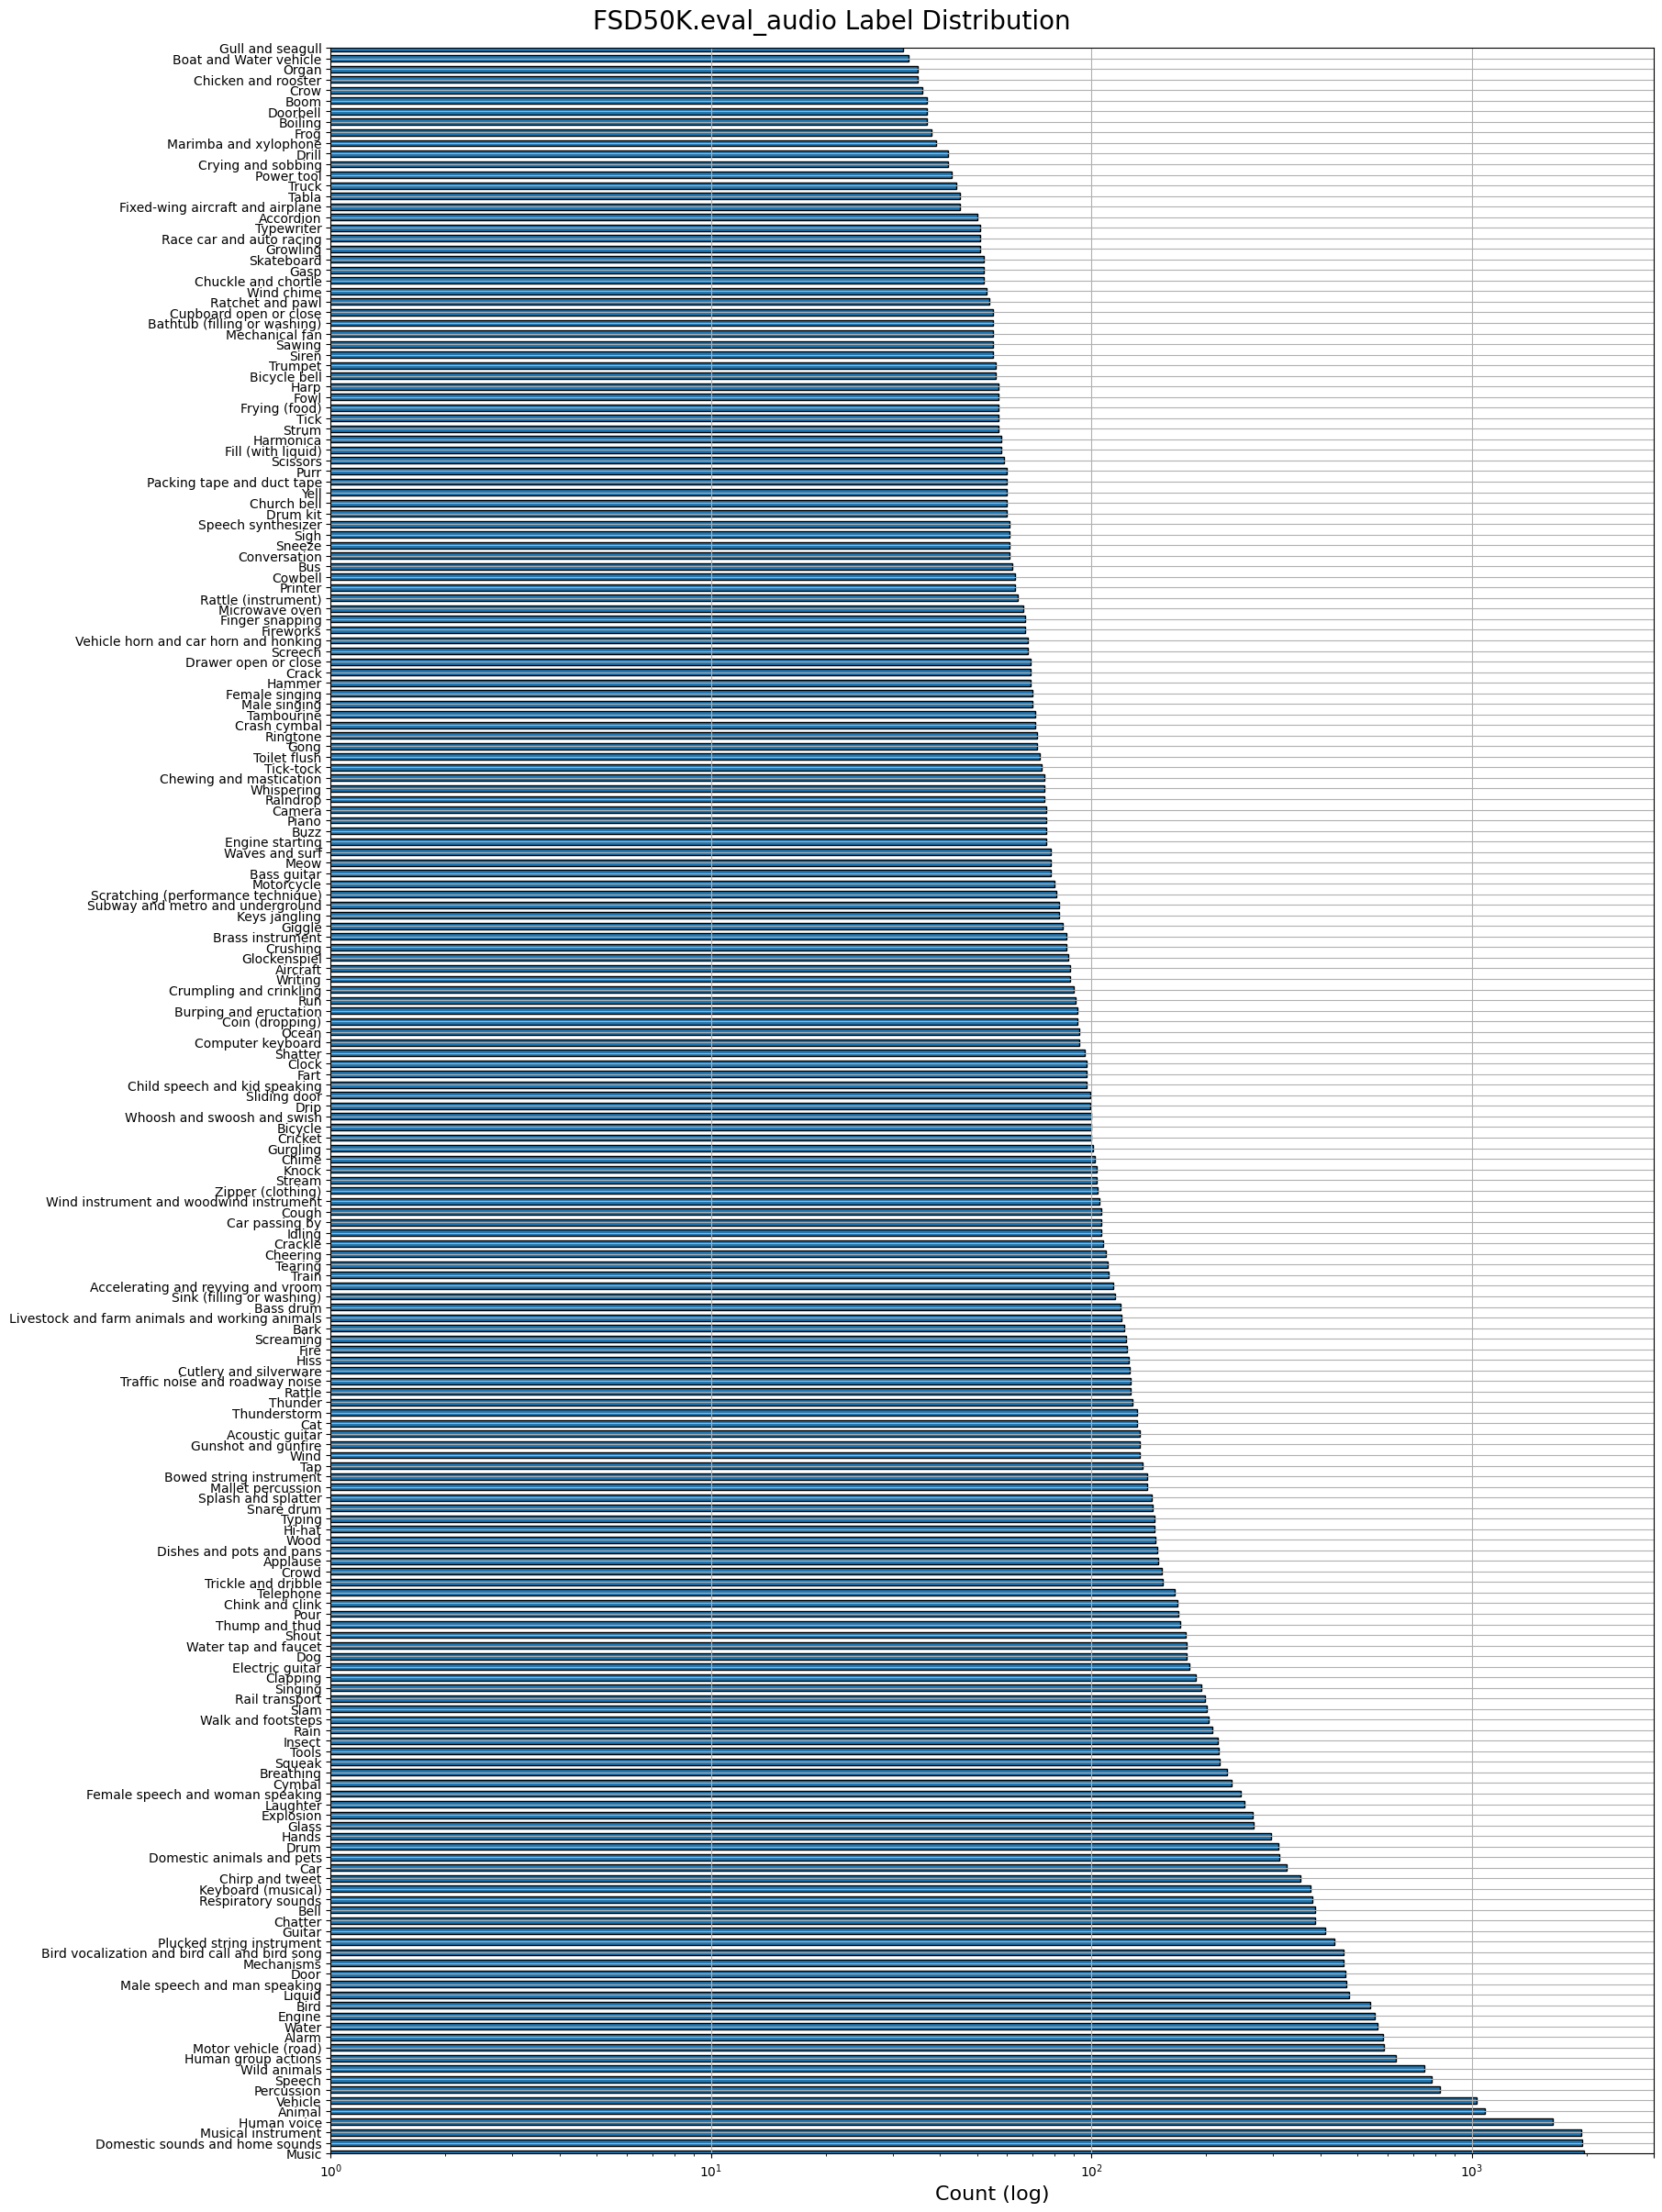

In [4]:
fig, ax = plt.subplots(figsize=(18, 24), constrained_layout=True)
fig.suptitle("FSD50K.eval_audio Label Distribution", fontsize=20)
names = [label.replace("_", " ") for label in fsd_label_counter.keys()]
counts = [count for _, count in fsd_label_counter.items()]
ax.barh(names, counts, height=0.6, edgecolor="black")
ax.set_ylim([names[0], names[-1]])
ax.set_xscale("log")
ax.set_xlabel("Count (log)", fontsize=16)
ax.set_xticks([1, 10, 100, 1000, 3000])
ax.grid()
#fig.savefig(os.path.join(figures_dir, "FSD50K.eval_audio_label_distribution.png"), dpi=300)
plt.show()

#### Cool

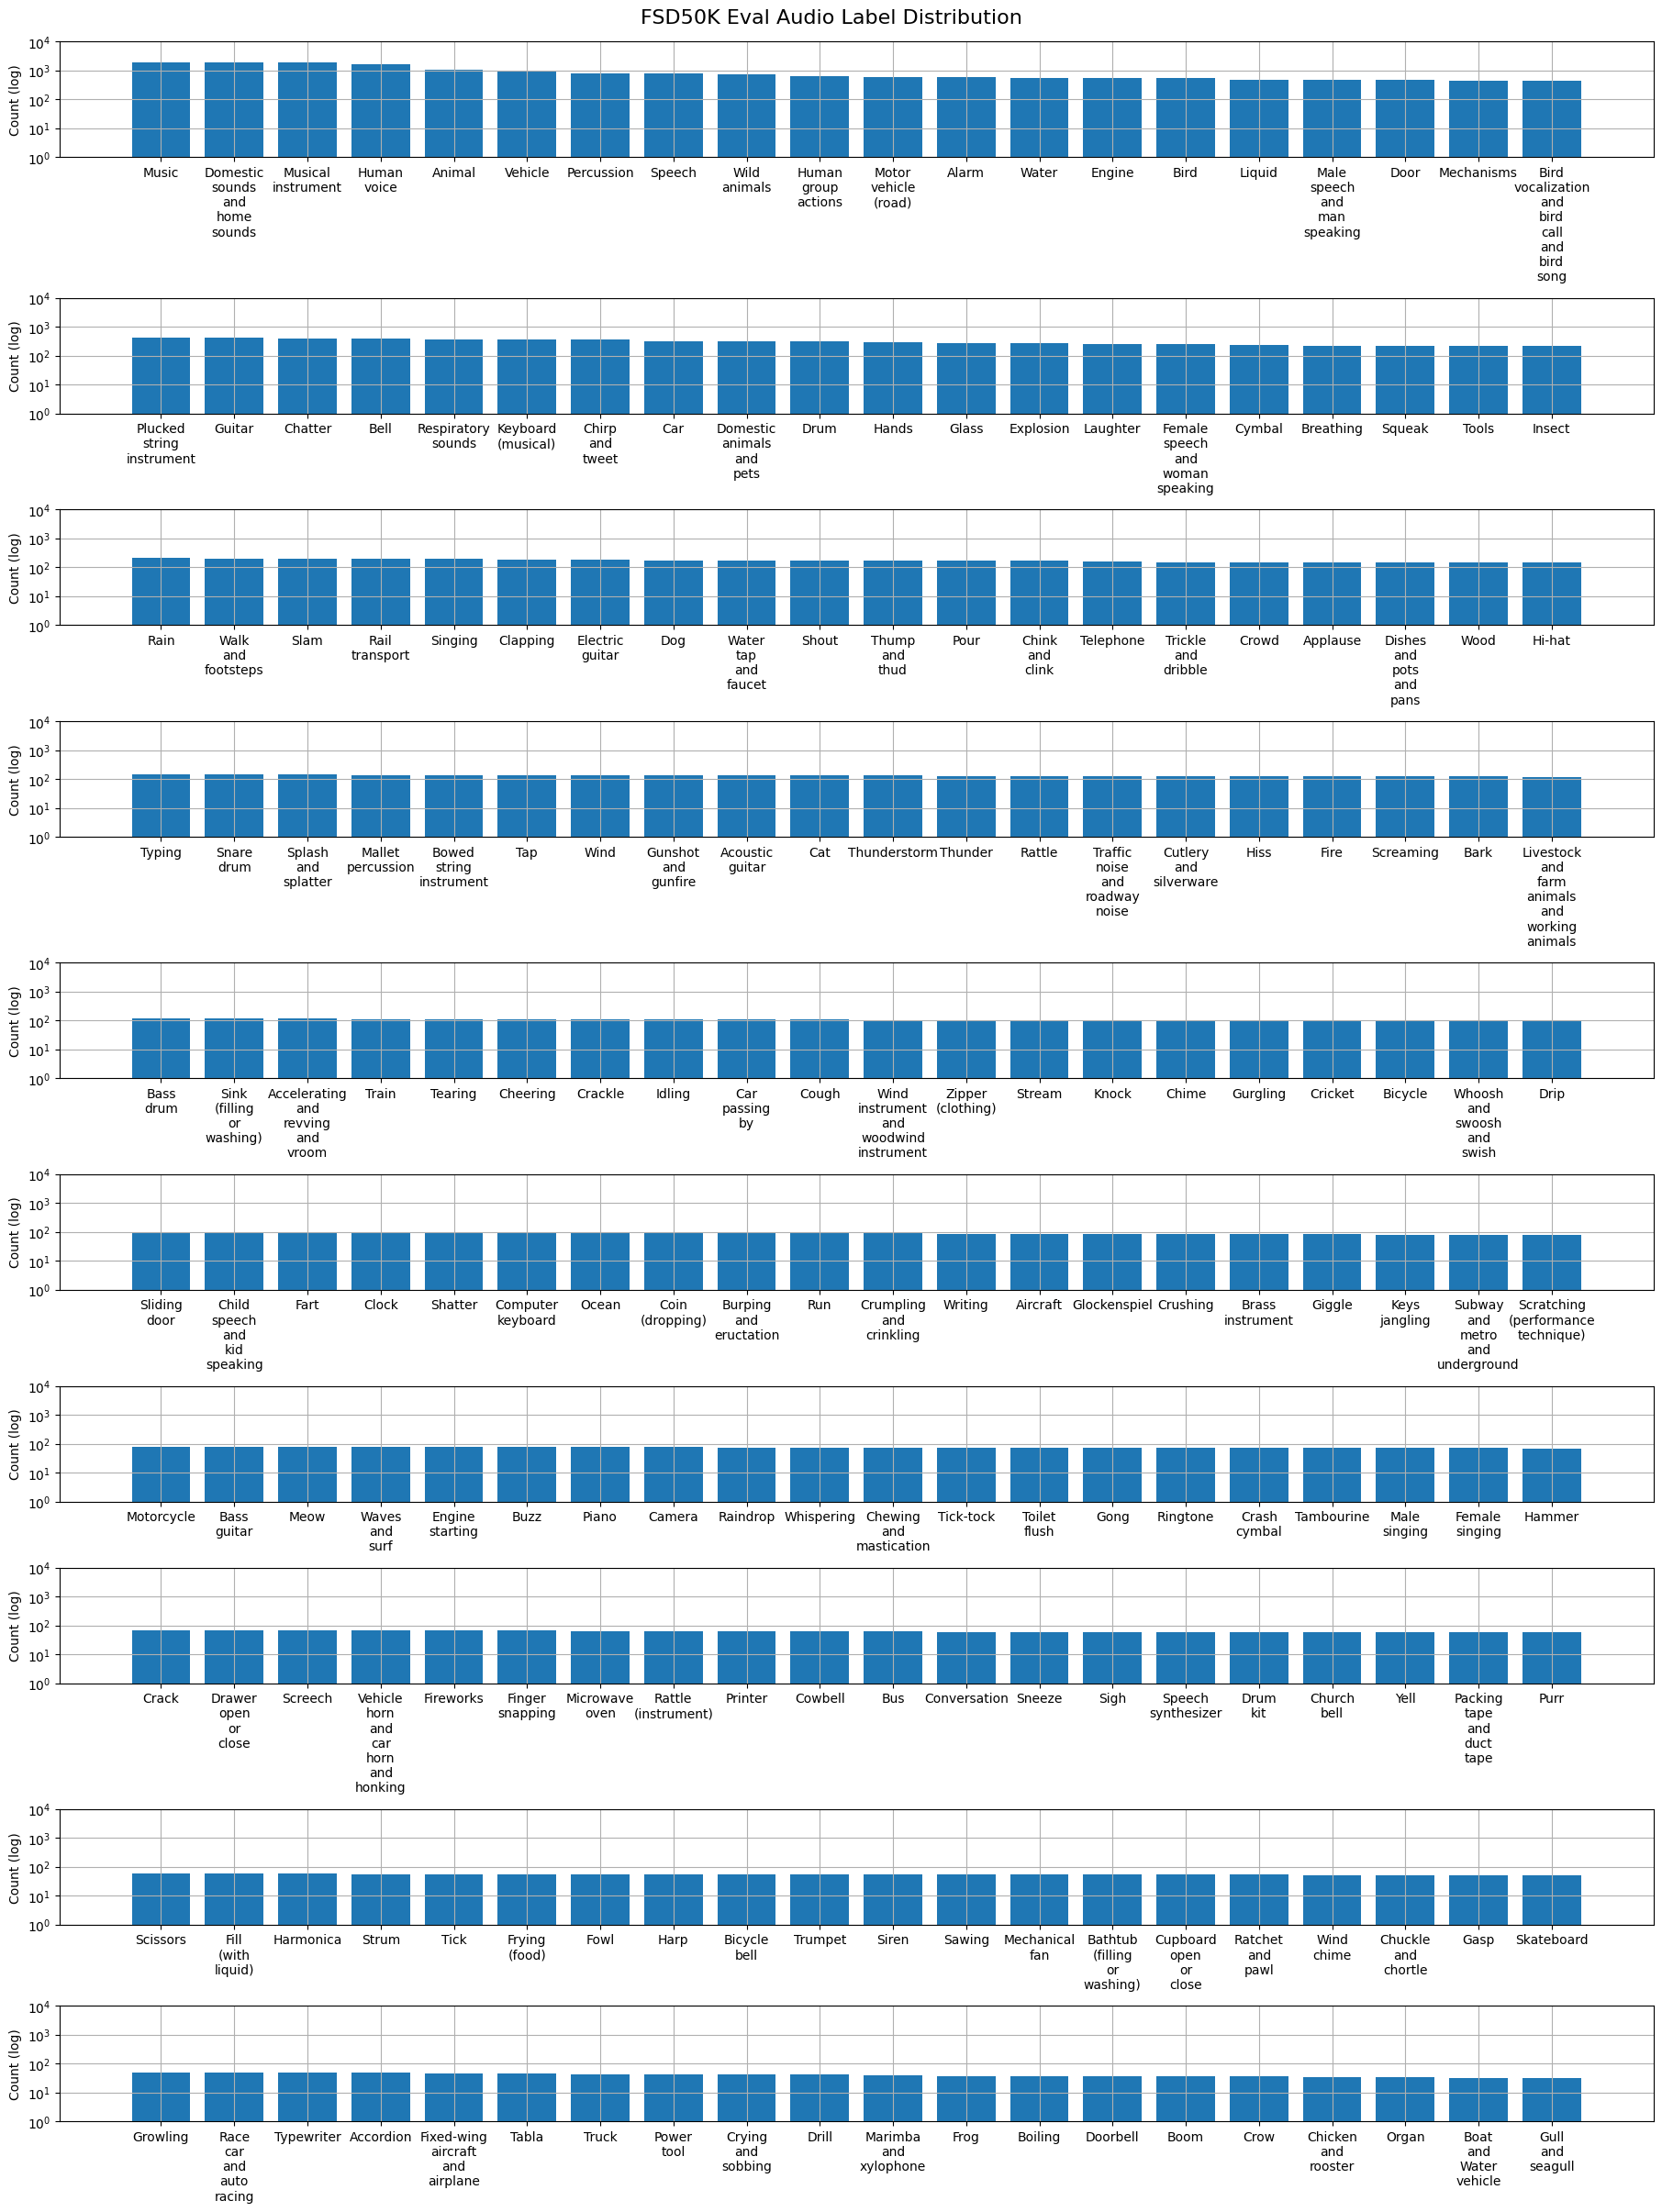

In [5]:
N = 10
delta = len(fsd_label_counter) // N
fig, ax = plt.subplots(figsize=(18, 24), nrows=N, constrained_layout=True)
fig.suptitle("FSD50K Eval Audio Label Distribution", fontsize=16)
for i in range(N):
    ax[i].bar([label.replace("_","\n") for label in list(fsd_label_counter.keys())[i*delta:(i+1)*delta]], 
              [count for count in list(fsd_label_counter.values())[i*delta:(i+1)*delta]])
    ax[i].set_ylim([1, 10**4])
    ax[i].set_ylabel("Count (log)")
    ax[i].set_yscale("log")
    ax[i].set_yticks(ticks = [1, 10, 100,1000,10000])
    ax[i].grid()
plt.show()

## Create Audioset and FSD50K Ontologies

### Scrape (or Load) Audioset to Create its Ontology

In [4]:
URL = "https://research.google.com/audioset/ontology/"

def format_name(name):
    if name=="Dishes, pots, and pans":
        return "Dishes_and_pots_and_pans"
    elif name.lower()=='boat, water vehicle':
        return "Boat_and_Water_vehicle"
    else:
        name = name[0].capitalize()+name[1:].lower()
        name = name.replace(" ", "_")
        name = name.replace(",", "_and")
        return name

def get_branch(branch_url):
    branch_response = requests.get(branch_url)
    if branch_response.status_code != 200:
        raise Exception(f"Failed to load {branch_url}.")
    else:
        info = []
        branch_soup = BeautifulSoup(branch_response.text, "html.parser")
        for leaf in branch_soup.find_all("li", {"class": "B"}):
            leaf = leaf.find("a")
            leaf_url = URL+leaf.get('href')
            leaf_name = leaf.text
            info.append((leaf_name, leaf_url))
    return info

def parse_audioset(name_format=False, load=False, save=False):

    ontology_path = "ontology/Audioset_ontology.json"

    if load:
        importer = JsonImporter()
        with open(os.path.join(DATA_DIR, ontology_path), "r") as infile:
            tree_dict = json.load(infile)
        root = importer.import_(json.dumps(tree_dict))
        return root
    else:
        response = requests.get(URL+"index.html")
        if response.status_code != 200:
            raise Exception("Failed to load the ontology page.")
        else:
            print("Successfully loaded the ontology page.")
            soup = BeautifulSoup(response.text, "html.parser")

            root = Node("root")
            for column in soup.find("div", {"id": "branches"}).find_all("div", {"class": "Pb"}):

                branches = column.find_all("h2", {"class": "n"})
                l1_info = [(branch.text, URL+branch.a.get('href')) for branch in branches]

                # Level 1
                for branch_name, branch_url in l1_info:
                    if name_format:
                        branch_name = format_name(branch_name)
                    l1_node = Node(branch_name, parent=root)
                    l2_info = get_branch(branch_url)

                    # Level 2
                    for l2_name, l2_url in l2_info:
                        if name_format:
                            l2_name = format_name(l2_name)
                        l2_node = Node(l2_name, parent=l1_node)
                        l3_info = get_branch(l2_url)

                        # Level 3
                        for l3_name, l3_url in l3_info:
                            if name_format:
                                l3_name = format_name(l3_name)
                            l3_node = Node(l3_name, parent=l2_node)
                            l4_info = get_branch(l3_url)

                            # Level 4
                            for l4_name, l4_url in l4_info:
                                if name_format:
                                    l4_name = format_name(l4_name)
                                l4_node = Node(l4_name, parent=l3_node)
                                l5_info = get_branch(l4_url)

                                # Level 5
                                for l5_name, l5_url in l5_info:
                                    if name_format:
                                        l5_name = format_name(l5_name)
                                    l5_node = Node(l5_name, parent=l4_node)
                                    l6_info = get_branch(l5_url)

                                    # Level 6
                                    for l6_name, l6_url in l6_info:
                                        if name_format:
                                            l6_name = format_name(l6_name)
                                        l6_node = Node(l6_name, parent=l5_node)

            if save:
                exporter = DictExporter()
                tree_dict = exporter.export(root)
                with open(os.path.join(DATA_DIR, ontology_path), "w") as outfile:
                    json.dump(tree_dict, outfile, indent=4)

            return root

In [5]:
audioset_ontology = parse_audioset(load=True, name_format=True, save=False)
print(RenderTree(audioset_ontology))

AnyNode(name='root')
├── AnyNode(name='Human_sounds')
│   ├── AnyNode(name='Human_voice')
│   │   ├── AnyNode(name='Speech')
│   │   │   ├── AnyNode(name='Male_speech_and_man_speaking')
│   │   │   ├── AnyNode(name='Female_speech_and_woman_speaking')
│   │   │   ├── AnyNode(name='Child_speech_and_kid_speaking')
│   │   │   ├── AnyNode(name='Conversation')
│   │   │   ├── AnyNode(name='Narration_and_monologue')
│   │   │   ├── AnyNode(name='Babbling')
│   │   │   └── AnyNode(name='Speech_synthesizer')
│   │   ├── AnyNode(name='Shout')
│   │   │   ├── AnyNode(name='Bellow')
│   │   │   ├── AnyNode(name='Whoop')
│   │   │   ├── AnyNode(name='Yell')
│   │   │   ├── AnyNode(name='Battle_cry')
│   │   │   └── AnyNode(name='Children_shouting')
│   │   ├── AnyNode(name='Screaming')
│   │   ├── AnyNode(name='Whispering')
│   │   ├── AnyNode(name='Laughter')
│   │   │   ├── AnyNode(name='Baby_laughter')
│   │   │   ├── AnyNode(name='Giggle')
│   │   │   ├── AnyNode(name='Snicker')
│   │   │   ├─

### Create FSD50K Ontology from Audioset Ontology

In [6]:
def check(name, children_list):
    for children in children_list:
        if name == children["name"]:
            return True
    return False

def get_full_name(node):
    full_name = []
    while node.name != "root":
        full_name.append(node.name)
        node = node.parent
    return full_name[::-1]

# Main families that we want to include in the visualization of FSD50K
INCLUDE = [
    "Natural_sounds",
    "Human_sounds",
    "Sounds_of_things",
    "Source-ambiguous_sounds",
]

In [7]:
audioset_nodes = [leaf for leaf in list(PreOrderIter(audioset_ontology, filter_=lambda node: node.name != "root"))]
print(f"There are {len(audioset_nodes)} nodes in Audioset")
unique_audioset_nodes = set([node.name for node in audioset_nodes])
print(f"There are {len(unique_audioset_nodes)} unique nodes in Audioset")

audioset_leaves = [leaf for leaf in list(PreOrderIter(audioset_ontology, filter_=lambda node: (node.is_leaf and node.name != "root")))]
print(f"There are {len(audioset_leaves)} leaf nodes in Audioset")
unique_audioset_leaf_nodes = set([node.name for node in audioset_leaves])
print(f"There are {len(unique_audioset_leaf_nodes)} unique leaf nodes in Audioset")

audioset_max_depth = max([leaf.depth for leaf in list(PreOrderIter(audioset_ontology, filter_=lambda node: node.name != "root"))])
print(f"The maximum depth of the Audioset ontology is {audioset_max_depth}")

audioset_node_branches = [get_full_name(node) for node in audioset_nodes]
audioset_main_families = set([b[0] for b in audioset_node_branches])
print(f"\nThere are {len(audioset_main_families)} main sound families.")
for i in audioset_main_families:
    print(i)

There are 690 nodes in Audioset
There are 632 unique nodes in Audioset
There are 526 leaf nodes in Audioset
There are 474 unique leaf nodes in Audioset
The maximum depth of the Audioset ontology is 6

There are 7 main sound families.
Animal
Human_sounds
Source-ambiguous_sounds
Music
Channel_and_environment_and_background
Natural_sounds
Sounds_of_things


In [8]:
# Find the FSD labels that are not in the Audioset ontology while mapping the FSD labels to the Audioset labels
mappings = {}
for fsd_label in fsd_labels:
    found = False
    for audioset_node_branch in audioset_node_branches:
        if fsd_label==audioset_node_branch[-1]:
            found = True
            mappings[fsd_label] = audioset_node_branch
            break
    if not found:
        print(fsd_label, "not found")

# Follow the branches of FSD label through the Audioset ontology and keep only intermediate nodes that are in the FSD labels
reduced_mappings, reduced_mappings_main = {}, {}
for fsd_label, audioset_branch in mappings.items():
    reduced_mappings[fsd_label] = [node for node in audioset_branch if node in fsd_labels]
    reduced_mappings_main[fsd_label] = [node for node in audioset_branch if (node in fsd_labels) or (node in INCLUDE)]
#print(json.dumps(reduced_mappings, indent=4))
print("Max reduced depth without main nodes: ", max([len(fsd_branch) for fsd_branch in reduced_mappings.values()]))
print("Max reduced depth with main nodes: ", max([len(fsd_branch) for fsd_branch in reduced_mappings_main.values()]))

Max reduced depth without main nodes:  5
Max reduced depth with main nodes:  5


#### Without Main Nodes

In [15]:
# Create the tree
fsd_ont = {"name": "root", "children": []}
for fsd_branch in reduced_mappings.values():

        if not check(fsd_branch[0], fsd_ont["children"]):
            fsd_ont["children"].append({"name": fsd_branch[0], "children": []})

        if len(fsd_branch) > 1:

            adress1 = [i for i, d in enumerate(fsd_ont["children"]) if d["name"] == fsd_branch[0]][0]
            if not check(fsd_branch[1], fsd_ont["children"][adress1]["children"]):
                fsd_ont["children"][adress1]["children"].append({"name": fsd_branch[1], "children": []})

            if len(fsd_branch) > 2:

                adress2 = [i for i, d in enumerate(fsd_ont["children"][adress1]["children"]) if d["name"] == fsd_branch[1]][0]
                if not check(fsd_branch[2], fsd_ont["children"][adress1]["children"][adress2]["children"]):
                    fsd_ont["children"][adress1]["children"][adress2]["children"].append({"name": fsd_branch[2], "children": []})

                if len(fsd_branch) > 3:
                    address3 = [i for i, d in enumerate(fsd_ont["children"][adress1]["children"][adress2]["children"]) if d["name"] == fsd_branch[2]][0]
                    if not check(fsd_branch[3], fsd_ont["children"][adress1]["children"][adress2]["children"][address3]["children"]):
                        fsd_ont["children"][adress1]["children"][adress2]["children"][address3]["children"].append({"name": fsd_branch[3], "children": []})

                    if len(fsd_branch) > 4:
                        address4 = [i for i, d in enumerate(fsd_ont["children"][adress1]["children"][adress2]["children"][address3]["children"]) if d["name"] == fsd_branch[3]][0]
                        if not check(fsd_branch[4], fsd_ont["children"][adress1]["children"][adress2]["children"][address3]["children"][address4]["children"]):
                            fsd_ont["children"][adress1]["children"][adress2]["children"][address3]["children"][address4]["children"].append({"name": fsd_branch[4], "children": []})

# Prune the nodes with no children
for c in fsd_ont["children"]:
    if c["children"]==[]:
        del c["children"]
    else:
        for cc in c["children"]:
            if cc["children"]==[]:
                del cc["children"]
            else:
                for ccc in cc["children"]:
                    if ccc["children"]==[]:
                        del ccc["children"]
                    else:
                        for cccc in ccc["children"]:
                            if cccc["children"]==[]:
                                del cccc["children"]
                            else:
                                for ccccc in cccc["children"]:
                                    if ccccc["children"]==[]:
                                        del ccccc["children"]

# with open(os.path.join(DATA_DIR, "ontology/FSD50K_ontology.json"), "w") as outfile:
    # json.dump(fsd_ont, outfile, indent=4)

 # Render the tree
importer = DictImporter()
fsd_ont = importer.import_(fsd_ont)
print(RenderTree(fsd_ont))

AnyNode(name='root')
├── AnyNode(name='Music')
│   └── AnyNode(name='Musical_instrument')
│       ├── AnyNode(name='Percussion')
│       │   ├── AnyNode(name='Drum')
│       │   │   ├── AnyNode(name='Snare_drum')
│       │   │   ├── AnyNode(name='Bass_drum')
│       │   │   └── AnyNode(name='Tabla')
│       │   ├── AnyNode(name='Cymbal')
│       │   │   ├── AnyNode(name='Hi-hat')
│       │   │   └── AnyNode(name='Crash_cymbal')
│       │   ├── AnyNode(name='Mallet_percussion')
│       │   │   ├── AnyNode(name='Glockenspiel')
│       │   │   └── AnyNode(name='Marimba_and_xylophone')
│       │   ├── AnyNode(name='Gong')
│       │   ├── AnyNode(name='Tambourine')
│       │   ├── AnyNode(name='Rattle_(instrument)')
│       │   └── AnyNode(name='Drum_kit')
│       ├── AnyNode(name='Plucked_string_instrument')
│       │   └── AnyNode(name='Guitar')
│       │       ├── AnyNode(name='Electric_guitar')
│       │       ├── AnyNode(name='Acoustic_guitar')
│       │       ├── AnyNode(name='Bass_gu

Add numbers

In [34]:
for child in fsd_onth.children:
    name = child.name
    n = len(df[find_indices_containing_label(name, df)])
    child.name = name + f'_[{n}]'
    for grandchild in child.children:
        name = grandchild.name
        n = len(df[find_indices_containing_label(name, df)])
        grandchild.name = name + f'_[{n}]'
        for greatgrandchild in grandchild.children:
            name = greatgrandchild.name
            n = len(df[find_indices_containing_label(name, df)])
            greatgrandchild.name = name + f'_[{n}]'
            for greatgreatgrandchild in greatgrandchild.children:
                name = greatgreatgrandchild.name
                n = len(df[find_indices_containing_label(name, df)])
                greatgreatgrandchild.name = name + f'_[{n}]'
                for greatgreatgreatgrandchild in greatgreatgrandchild.children:
                    name = greatgreatgreatgrandchild.name
                    n = len(df[find_indices_containing_label(name, df)])
                    greatgreatgreatgrandchild.name = name + f'_[{n}]'
print(RenderTree(fsd_onth))
# exporter = DictExporter()
# exp = exporter.export(fsd_ontology)
# with open(os.path.join(DATA_DIR, "ontology" ,"FSD50K_ontology-counts.json"), "w") as outfile:
#     json.dump(exp, outfile, indent=4)

AnyNode(name='root')
├── AnyNode(name='Music_[1972]')
│   └── AnyNode(name='Musical_instrument_[1940]')
│       ├── AnyNode(name='Percussion_[825]')
│       │   ├── AnyNode(name='Drum_[310]')
│       │   │   ├── AnyNode(name='Snare_drum_[145]')
│       │   │   ├── AnyNode(name='Bass_drum_[119]')
│       │   │   └── AnyNode(name='Tabla_[45]')
│       │   ├── AnyNode(name='Cymbal_[234]')
│       │   │   ├── AnyNode(name='Hi-hat_[146]')
│       │   │   └── AnyNode(name='Crash_cymbal_[71]')
│       │   ├── AnyNode(name='Mallet_percussion_[140]')
│       │   │   ├── AnyNode(name='Glockenspiel_[87]')
│       │   │   └── AnyNode(name='Marimba_and_xylophone_[39]')
│       │   ├── AnyNode(name='Gong_[72]')
│       │   ├── AnyNode(name='Tambourine_[71]')
│       │   ├── AnyNode(name='Rattle_(instrument)_[64]')
│       │   └── AnyNode(name='Drum_kit_[60]')
│       ├── AnyNode(name='Plucked_string_instrument_[434]')
│       │   └── AnyNode(name='Guitar_[411]')
│       │       ├── AnyNode(name='Ele

#### With Main Nodes

In [9]:
# Create the tree
fsd_ont_with_main = {"name": "root", "children": []}
for fsd_branch in reduced_mappings_main.values():

    if fsd_branch[0] in INCLUDE and not check(fsd_branch[0], fsd_ont_with_main["children"]):
        fsd_ont_with_main["children"].append({"name": fsd_branch[0], "children": []})

    if not check(fsd_branch[0], fsd_ont_with_main["children"]):
        fsd_ont_with_main["children"].append({"name": fsd_branch[0], "children": []})

    if len(fsd_branch) > 1:

        adress1 = [i for i, d in enumerate(fsd_ont_with_main["children"]) if d["name"] == fsd_branch[0]][0]
        if not check(fsd_branch[1], fsd_ont_with_main["children"][adress1]["children"]):
            fsd_ont_with_main["children"][adress1]["children"].append({"name": fsd_branch[1], "children": []})

        if len(fsd_branch) > 2:

            adress2 = [i for i, d in enumerate(fsd_ont_with_main["children"][adress1]["children"]) if d["name"] == fsd_branch[1]][0]
            if not check(fsd_branch[2], fsd_ont_with_main["children"][adress1]["children"][adress2]["children"]):
                fsd_ont_with_main["children"][adress1]["children"][adress2]["children"].append({"name": fsd_branch[2], "children": []})

            if len(fsd_branch) > 3:
                address3 = [i for i, d in enumerate(fsd_ont_with_main["children"][adress1]["children"][adress2]["children"]) if d["name"] == fsd_branch[2]][0]
                if not check(fsd_branch[3], fsd_ont_with_main["children"][adress1]["children"][adress2]["children"][address3]["children"]):
                    fsd_ont_with_main["children"][adress1]["children"][adress2]["children"][address3]["children"].append({"name": fsd_branch[3], "children": []})

                if len(fsd_branch) > 4:
                    address4 = [i for i, d in enumerate(fsd_ont_with_main["children"][adress1]["children"][adress2]["children"][address3]["children"]) if d["name"] == fsd_branch[3]][0]
                    if not check(fsd_branch[4], fsd_ont_with_main["children"][adress1]["children"][adress2]["children"][address3]["children"][address4]["children"]):
                        fsd_ont_with_main["children"][adress1]["children"][adress2]["children"][address3]["children"][address4]["children"].append({"name": fsd_branch[4], "children": []})

# Prune the nodes with no children
for c in fsd_ont_with_main["children"]:
    if c["children"]==[]:
        del c["children"]
    else:
        for cc in c["children"]:
            if cc["children"]==[]:
                del cc["children"]
            else:
                for ccc in cc["children"]:
                    if ccc["children"]==[]:
                        del ccc["children"]
                    else:
                        for cccc in ccc["children"]:
                            if cccc["children"]==[]:
                                del cccc["children"]
                            else:
                                for ccccc in cccc["children"]:
                                    if ccccc["children"]==[]:
                                        del ccccc["children"]

# with open(os.path.join(DATA_DIR, "ontology/FSD50K_ontology-with_main_nodes.json"), "w") as outfile:
#     json.dump(fsd_ont_with_main, outfile, indent=4)

 # Render the tree
importer = DictImporter()
fsd_ont_with_main = importer.import_(fsd_ont_with_main)
print(RenderTree(fsd_ont_with_main))

AnyNode(name='root')
├── AnyNode(name='Music')
│   └── AnyNode(name='Musical_instrument')
│       ├── AnyNode(name='Percussion')
│       │   ├── AnyNode(name='Drum')
│       │   │   ├── AnyNode(name='Snare_drum')
│       │   │   ├── AnyNode(name='Bass_drum')
│       │   │   └── AnyNode(name='Tabla')
│       │   ├── AnyNode(name='Cymbal')
│       │   │   ├── AnyNode(name='Hi-hat')
│       │   │   └── AnyNode(name='Crash_cymbal')
│       │   ├── AnyNode(name='Mallet_percussion')
│       │   │   ├── AnyNode(name='Glockenspiel')
│       │   │   └── AnyNode(name='Marimba_and_xylophone')
│       │   ├── AnyNode(name='Gong')
│       │   ├── AnyNode(name='Tambourine')
│       │   ├── AnyNode(name='Rattle_(instrument)')
│       │   └── AnyNode(name='Drum_kit')
│       ├── AnyNode(name='Plucked_string_instrument')
│       │   └── AnyNode(name='Guitar')
│       │       ├── AnyNode(name='Electric_guitar')
│       │       ├── AnyNode(name='Acoustic_guitar')
│       │       ├── AnyNode(name='Bass_gu

Add Numbers

In [10]:
for child in fsd_ont_with_main.children:
    name = child.name
    n = len(df[find_indices_containing_label(name, df)])
    child.name = name + f'_[{n}]'
    for grandchild in child.children:
        name = grandchild.name
        n = len(df[find_indices_containing_label(name, df)])
        grandchild.name = name + f'_[{n}]'
        for greatgrandchild in grandchild.children:
            name = greatgrandchild.name
            n = len(df[find_indices_containing_label(name, df)])
            greatgrandchild.name = name + f'_[{n}]'
            for greatgreatgrandchild in greatgrandchild.children:
                name = greatgreatgrandchild.name
                n = len(df[find_indices_containing_label(name, df)])
                greatgreatgrandchild.name = name + f'_[{n}]'
                for greatgreatgreatgrandchild in greatgreatgrandchild.children:
                    name = greatgreatgreatgrandchild.name
                    n = len(df[find_indices_containing_label(name, df)])
                    greatgreatgreatgrandchild.name = name + f'_[{n}]'
print(RenderTree(fsd_ont_with_main))
# exporter = DictExporter()
# exp = exporter.export(fsd_ontology_with_main)
# with open(os.path.join(DATA_DIR, "ontology" ,"FSD50K_ontology-with_main_nodes-counts.json"), "w") as outfile:
#     json.dump(exp, outfile, indent=4)

AnyNode(name='root')
├── AnyNode(name='Music_[1972]')
│   └── AnyNode(name='Musical_instrument_[1940]')
│       ├── AnyNode(name='Percussion_[825]')
│       │   ├── AnyNode(name='Drum_[310]')
│       │   │   ├── AnyNode(name='Snare_drum_[145]')
│       │   │   ├── AnyNode(name='Bass_drum_[119]')
│       │   │   └── AnyNode(name='Tabla_[45]')
│       │   ├── AnyNode(name='Cymbal_[234]')
│       │   │   ├── AnyNode(name='Hi-hat_[146]')
│       │   │   └── AnyNode(name='Crash_cymbal_[71]')
│       │   ├── AnyNode(name='Mallet_percussion_[140]')
│       │   │   ├── AnyNode(name='Glockenspiel_[87]')
│       │   │   └── AnyNode(name='Marimba_and_xylophone_[39]')
│       │   ├── AnyNode(name='Gong_[72]')
│       │   ├── AnyNode(name='Tambourine_[71]')
│       │   ├── AnyNode(name='Rattle_(instrument)_[64]')
│       │   └── AnyNode(name='Drum_kit_[60]')
│       ├── AnyNode(name='Plucked_string_instrument_[434]')
│       │   └── AnyNode(name='Guitar_[411]')
│       │       ├── AnyNode(name='Ele

## FSD Labels With Multiple Parents

### Load the Ontologies and find Multiple

In [11]:
with open(os.path.join(DATA_DIR, "ontology/Audioset_ontology.json"), "r") as f:
    audioset_ontology_dict = json.load(f)
audioset_ontology = DictImporter().import_(audioset_ontology_dict)

with open(os.path.join(DATA_DIR, "ontology/FSD50K_ontology.json"), "r") as f:
    fsd_ontology_dict = json.load(f)
fsd_ontology = DictImporter().import_(fsd_ontology_dict)

In [12]:
# Find which FSD labels appear in multiple places in the Audioset onthology
multiple_occur = []
for fsd_node in list(PreOrderIter(fsd_ontology, filter_=lambda node: node.name != "root")):
    audioset_appearances = []
    for audioset_node in list(PreOrderIter(audioset_ontology, filter_=lambda node: node.name != "root")):
        if fsd_node.name == audioset_node.name:
            audioset_appearances.append(audioset_node)
    if len(audioset_appearances) > 1:
        multiple_occur.append(fsd_node)
print(f"There are {len(multiple_occur)} FSD labels that appear in multiple places in the Audioset ontology.\n")

for fsd_node in multiple_occur:
    print(fsd_node.name)
    for audioset_node in list(PreOrderIter(audioset_ontology, filter_=lambda node: node.name != "root")):
        if fsd_node.name == audioset_node.name:
            print(get_full_name(audioset_node))
    print()

There are 22 FSD labels that appear in multiple places in the Audioset ontology.

Doorbell
['Sounds_of_things', 'Domestic_sounds_and_home_sounds', 'Door', 'Doorbell']
['Sounds_of_things', 'Alarm', 'Doorbell']

Growling
['Animal', 'Domestic_animals_and_pets', 'Dog', 'Growling']
['Animal', 'Domestic_animals_and_pets', 'Cat', 'Growling']
['Animal', 'Wild_animals', 'Roaring_cats_(lions_and_tigers)', 'Growling']
['Animal', 'Wild_animals', 'Canidae_and_dogs_and_wolves', 'Growling']

Cowbell
['Animal', 'Livestock_and_farm_animals_and_working_animals', 'Cattle_and_bovinae', 'Cowbell']
['Sounds_of_things', 'Bell', 'Cowbell']
['Music', 'Musical_instrument', 'Percussion', 'Cowbell']
['Music', 'Musical_instrument', 'Bell', 'Cowbell']

Vehicle_horn_and_car_horn_and_honking
['Sounds_of_things', 'Vehicle', 'Motor_vehicle_(road)', 'Car', 'Vehicle_horn_and_car_horn_and_honking']
['Sounds_of_things', 'Alarm', 'Vehicle_horn_and_car_horn_and_honking']

Bicycle_bell
['Sounds_of_things', 'Vehicle', 'Non-mot

In [13]:
multi_occur_labels = [node.name for node in multiple_occur]
multi_occur_labels

['Doorbell',
 'Growling',
 'Cowbell',
 'Vehicle_horn_and_car_horn_and_honking',
 'Bicycle_bell',
 'Bell',
 'Chime',
 'Wind_chime',
 'Church_bell',
 'Chirp_and_tweet',
 'Clapping',
 'Squeak',
 'Thump_and_thud',
 'Tap',
 'Rattle',
 'Hiss',
 'Crackle',
 'Knock',
 'Whoosh_and_swoosh_and_swish',
 'Buzz',
 'Crack',
 'Tick']

### Load the "Propagate to Parents"

In [16]:
# Load the propagate to parent file to see what the authors think about these labels
with open(os.path.join(DATA_DIR, "ontology/ontology_crowd.json"), "r") as f:
    ontology_crowd = json.load(f)

name_ids = {}
for label in ontology_crowd:
    name_ids[label["id"]] = label["name"]

In [17]:
def clean(label):
    return label.replace("_", " ").replace(" and ", ", ")

def distort(label):
    return label.replace(", ", " and ").replace(" ", "_")

In [18]:
for label in multi_occur_labels:
    found=False
    for _label in ontology_crowd:
        if clean(label) == _label["name"]:
            found=True
            break
    if not found:
        print(label)

In [19]:
i = 0
for label in ontology_crowd:
    if distort(label["name"]) in multi_occur_labels:
        print(label['name'])
        i += 1
print(i)

Clapping
Growling
Hiss
Cowbell
Chirp, tweet
Buzz
Rattle
Bell
Church bell
Bicycle bell
Chime
Wind chime
Crackle
Vehicle horn, car horn, honking
Doorbell
Knock
Tap
Squeak
Tick
Crack
Whoosh, swoosh, swish
Thump, thud
22


In [20]:
n_parents, multi_possible_parents, zero_parents, single_parents = [], [], [], []
for label in ontology_crowd:
    if distort(label["name"]) in multi_occur_labels:
        if "propagate_to_parents" in label:
            n = len(label['propagate_to_parents'])
            n_parents.append(n)
            if n > 1:
                multi_possible_parents.append([label['name'], [name_ids[_id] for _id in label['propagate_to_parents']]])
            elif n == 0:
                zero_parents.append(label['name'])
            else:
                single_parents.append([label['name'], name_ids[label['propagate_to_parents'][0]]])
print(f"Set of number of possible parents: {set(n_parents)}")

print("\nNodes with no propagation parents:")
for parent in zero_parents:
    print(parent)

print("\nNodes with Single propagation parents:")
for parent in single_parents:
    print(f"child: {parent[0]}, parent: {parent[1]}")

print("\nNodes with Multiple Possible propagation parents parents:")
for parent in multi_possible_parents:
    print(parent)

Set of number of possible parents: {0, 1, 2, 3}

Nodes with no propagation parents:
Growling
Buzz

Nodes with Single propagation parents:
child: Clapping, parent: Hands
child: Hiss, parent: Onomatopoeia
child: Cowbell, parent: Bell
child: Rattle, parent: Onomatopoeia
child: Bell, parent: Sounds of things
child: Church bell, parent: Bell
child: Chime, parent: Bell
child: Wind chime, parent: Chime
child: Crackle, parent: Onomatopoeia
child: Knock, parent: Generic impact sounds
child: Tap, parent: Generic impact sounds
child: Squeak, parent: Brief tone
child: Tick, parent: Clicking
child: Crack, parent: Onomatopoeia
child: Whoosh, swoosh, swish, parent: Onomatopoeia
child: Thump, thud, parent: Generic impact sounds

Nodes with Multiple Possible propagation parents parents:
['Chirp, tweet', ['Bird vocalization, bird call, bird song', 'Brief tone']]
['Bicycle bell', ['Bell', 'Bicycle', 'Alarm']]
['Vehicle horn, car horn, honking', ['Car', 'Alarm']]
['Doorbell', ['Door', 'Alarm']]


#### Listen to the problematic labels

In [38]:
fnames_of_interest = dict()
for label in zero_parents:
    fnames_of_interest[label] = df[find_indices_containing_label(label, df)]["fname"].to_list()
    print(f"{label}: {len(fnames_of_interest[label])}")

Growling: 51
Buzz: 76


In [60]:
label = "Buzz"
fname = random.choice(fnames_of_interest[label])
print(f"fname: {fname}")
print("\nLabels:")
print(df[df["fname"]==fname]["labels"].to_list()[0])
audio_path = os.path.join(AUDIO_DIR, str(fname)+".wav")
ipd.display(ipd.Audio(audio_path))

fname: 154851

Labels:
Buzz,Human_voice,Insect,Wild_animals,Animal


In [73]:
fnames_of_interest = dict()
for label in [distort(label[0]) for label in single_parents]:
    fnames_of_interest[label] = df[find_indices_containing_label(label, df)]["fname"].to_list()
    print(f"{label}: {len(fnames_of_interest[label])}")

Clapping: 188
Hiss: 125
Cowbell: 63
Rattle: 127
Bell: 386
Church_bell: 60
Chime: 102
Wind_chime: 53
Crackle: 107
Knock: 103
Tap: 136
Squeak: 217
Tick: 57
Crack: 69
Whoosh_and_swoosh_and_swish: 100
Thump_and_thud: 171


In [74]:
label = "Clapping"
for _label in ontology_crowd:
    if distort(_label["name"]) == label:
        print(_label['description'])

fname = random.choice(fnames_of_interest[label])
print(f"fname: {fname}")
print("\nLabels:")
print(df[df["fname"]==fname]["labels"].to_list()[0])
audio_path = os.path.join(AUDIO_DIR, str(fname)+".wav")
ipd.display(ipd.Audio(audio_path))

A percussive sound made by a human striking together the palms of their two hands, often quickly and repeatedly to express appreciation or approval. This category is to be used for distinct claps by a single person; for a group of people clapping together, use Applause.
fname: 255856

Labels:
Applause,Crowd,Cheering,Clapping,Drum,Shout,Percussion,Musical_instrument,Music,Human_group_actions,Human_voice,Hands


In [55]:
fnames_of_interest = dict()
for label in [distort(label[0]) for label in multi_possible_parents]:
    fnames_of_interest[label] = df[find_indices_containing_label(label, df)]["fname"].to_list()
    print(f"{label}: {len(fnames_of_interest[label])}")

Chirp_and_tweet: 354
Bicycle_bell: 56
Vehicle_horn_and_car_horn_and_honking: 68
Doorbell: 37


In [71]:
label = "Bicycle_bell"
for _label in ontology_crowd:
    if distort(_label["name"]) == label:
        print(_label['description'])

fname = random.choice(fnames_of_interest[label])
print(f"fname: {fname}")
print("\nLabels:")
print(df[df["fname"]==fname]["labels"].to_list()[0])
audio_path = os.path.join(AUDIO_DIR, str(fname)+".wav")
ipd.display(ipd.Audio(audio_path))

The sound of a percussive signaling instrument mounted on a bicycle for warning pedestrians and other cyclists.
fname: 210262

Labels:
Bicycle_bell,Bicycle,Vehicle,Alarm,Bell


In [36]:
propagate = [
    ["Growling", "Animal"], # Not specified but no other option
    #["Buzz", None], # Not specified
    ["Clapping", "Hands"],
    ["Hiss", 'Source-ambiguous_sounds'], # Onomatopoeia
    ["Bell", "Sounds_of_things"],
    ["Cowbell", "Bell"],
    ["Church_bell", "Bell"],
    ["Chime", "Bell"],
    ["Wind_chime", "Chime"],
    ["Rattle", "Source-ambiguous_sounds"], # Onomatopoeia
    ["Crackle", "Source-ambiguous_sounds"], # Onomatopoeia
    ["Knock", "Source-ambiguous_sounds"], # Generic_impact_sounds
    ["Tap", "Source-ambiguous_sounds"], # Generic_impact_sounds
    ["Squeak", "Source-ambiguous_sounds"], # Brief_tone
    ["Tick", "Source-ambiguous_sounds"], # Clicking
    ["Crack", "Source-ambiguous_sounds"], # Onomatopoeia
    ["Whoosh_and_swoosh_and_swish", "Source-ambiguous_sounds"], # Onomatopoeia
    ["Thump_and_thud", "Source-ambiguous_sounds"] # Generic_impact_sounds
]

do_not_propagate = [
    "Buzz", # We should listen to this. Maybe the family is clear
    "Chirp_and_tweet",
    "Bicycle_bell",
    "Vehicle_horn_and_car_horn_and_honking", #
    "Doorbell", # Parents are siblings at Sounds_of_things
]


In [82]:
for label in ontology_crowd:
    if label["name"] in {"Hiss"}:#{"Growling", "Buzz"}:
        print(json.dumps(label, indent=4))
        print()

{
    "citation_uri": "http://wordnetweb.princeton.edu/perl/webwn?s=hiss",
    "restrictions": [],
    "description": "A fricative sound, such as from a cat giving warning, or an audience indicating disapproval.",
    "child_ids": [],
    "negative_examples_FS": [
        238934,
        328729,
        242402
    ],
    "positive_examples": [
        "youtu.be/7fuyNj3y8z8?start=30&end=40",
        "youtu.be/sNFrUosKoq4?start=140&end=150",
        "youtu.be/3GkJeelJCB0?start=30&end=40",
        "youtu.be/uN4LHeFWBHY?start=30&end=40",
        "youtu.be/l4fED3GwuwY?start=30&end=40",
        "youtu.be/-dN7rnGYtNQ?start=30&end=40",
        "youtu.be/5wScdWqlS0c?start=30&end=40"
    ],
    "omit_fs_tags": [
        "beat",
        "dance"
    ],
    "fs_tags": [
        "hiss",
        "hissing",
        "steam"
    ],
    "positive_examples_FS": [
        146963,
        146961
    ],
    "propagate_to_parents": [
        "/m/05n1m"
    ],
    "id": "/m/07rjwbb",
    "name": "Hiss"
}



### Construct FSD50K Taxonomy

We load an ontology file and remove the nodes that are in multi_occur_labels. After this process, we obtain a taxonomy.

In [26]:
importer = DictImporter()
with open(os.path.join(DATA_DIR, "ontology/FSD50K_ontology-with_main_nodes-counts.json"), "r") as infile:
    fsd_ontology_dict_with_main = json.load(infile)
fsd_ontology_with_main_counts = importer.import_(fsd_ontology_dict_with_main)
print(RenderTree(fsd_ontology_with_main_counts))

AnyNode(name='root')
├── AnyNode(name='Music_[1972]')
│   └── AnyNode(name='Musical_instrument_[1940]')
│       ├── AnyNode(name='Percussion_[825]')
│       │   ├── AnyNode(name='Drum_[310]')
│       │   │   ├── AnyNode(name='Snare_drum_[145]')
│       │   │   ├── AnyNode(name='Bass_drum_[119]')
│       │   │   └── AnyNode(name='Tabla_[45]')
│       │   ├── AnyNode(name='Cymbal_[234]')
│       │   │   ├── AnyNode(name='Hi-hat_[146]')
│       │   │   └── AnyNode(name='Crash_cymbal_[71]')
│       │   ├── AnyNode(name='Mallet_percussion_[140]')
│       │   │   ├── AnyNode(name='Glockenspiel_[87]')
│       │   │   └── AnyNode(name='Marimba_and_xylophone_[39]')
│       │   ├── AnyNode(name='Gong_[72]')
│       │   ├── AnyNode(name='Tambourine_[71]')
│       │   ├── AnyNode(name='Rattle_(instrument)_[64]')
│       │   └── AnyNode(name='Drum_kit_[60]')
│       ├── AnyNode(name='Plucked_string_instrument_[434]')
│       │   └── AnyNode(name='Guitar_[411]')
│       │       ├── AnyNode(name='Ele

In [27]:
root = Node("root")
for main_node in fsd_ontology_with_main_counts.children:

    node0 = Node(main_node.name, parent=root)

    for child in main_node.children:

        if re.sub(r"_\[\d+\]", "", child.name) not in multi_occur_labels:
            node1 = Node(child.name, parent=node0)

        for grandchild in child.children:

            if re.sub(r"_\[\d+\]", "", grandchild.name) not in multi_occur_labels:
                node2 = Node(grandchild.name, parent=node1)

            for greatgrandchild in grandchild.children:

                if re.sub(r"_\[\d+\]", "", greatgrandchild.name) not in multi_occur_labels:
                    node3 = Node(greatgrandchild.name, parent=node2)

                for greatgreatgrandchild in greatgrandchild.children:

                    if re.sub(r"_\[\d+\]", "", greatgreatgrandchild.name) not in multi_occur_labels:
                        node4 = Node(greatgreatgrandchild.name, parent=node3)

                    for greatgreatgreatgrandchild in greatgreatgrandchild.children:

                        if re.sub(r"_\[\d+\]", "", greatgreatgreatgrandchild.name) not in multi_occur_labels:
                            node5 = Node(greatgreatgreatgrandchild.name, parent=node4)

print(RenderTree(root))

# exporter = DictExporter()
# x = exporter.export(root)
# with open(os.path.join(DATA_DIR, "ontology/FSD50K_taxonomy-with_main_nodes-counts.json"), "w") as outfile:
#     json.dump(x, outfile, indent=4)

Node('/root')
├── Node('/root/Music_[1972]')
│   └── Node('/root/Music_[1972]/Musical_instrument_[1940]')
│       ├── Node('/root/Music_[1972]/Musical_instrument_[1940]/Percussion_[825]')
│       │   ├── Node('/root/Music_[1972]/Musical_instrument_[1940]/Percussion_[825]/Drum_[310]')
│       │   │   ├── Node('/root/Music_[1972]/Musical_instrument_[1940]/Percussion_[825]/Drum_[310]/Snare_drum_[145]')
│       │   │   ├── Node('/root/Music_[1972]/Musical_instrument_[1940]/Percussion_[825]/Drum_[310]/Bass_drum_[119]')
│       │   │   └── Node('/root/Music_[1972]/Musical_instrument_[1940]/Percussion_[825]/Drum_[310]/Tabla_[45]')
│       │   ├── Node('/root/Music_[1972]/Musical_instrument_[1940]/Percussion_[825]/Cymbal_[234]')
│       │   │   ├── Node('/root/Music_[1972]/Musical_instrument_[1940]/Percussion_[825]/Cymbal_[234]/Hi-hat_[146]')
│       │   │   └── Node('/root/Music_[1972]/Musical_instrument_[1940]/Percussion_[825]/Cymbal_[234]/Crash_cymbal_[71]')
│       │   ├── Node('/root/Musi

In [124]:
# Export the families of the FSD50K taxonomy
families = {}
for main_node in root.children:

    families[re.sub(r"_\[\d+\]", "", main_node.name)] = [re.sub(r"_\[\d+\]", "", node.name) for node in PreOrderIter(main_node)]

# with open(os.path.join(DATA_DIR, "ontology/FSD50K_taxonomy-families.json"), "w") as outfile:
#     json.dump(families, outfile, indent=4)

#### Adjust The DataFrame

In [6]:
def get_full_name(node):
    full_name = []
    while node.name != "root":
        full_name.append(node.name)
        node = node.parent
    return full_name[::-1]

Remove files with multi-parent labels from the DataFrame

In [24]:
mapping_dict = {}
for leaf in list(PreOrderIter(fsd_onthology, filter_=lambda node: node.name != "root")):
    mapping_dict[leaf.name] = {"path": get_full_name(leaf),
                               "siblings": [sibling.name for sibling in leaf.siblings],
                               "children": [child.name for child in leaf.children],
                               "parent": leaf.parent.name if leaf.parent else None,
                               "depth": leaf.depth,
                               }

In [25]:
mapping_dict["Conversation"]

{'path': ['Human_voice', 'Speech', 'Conversation'],
 'siblings': ['Male_speech_and_man_speaking',
  'Female_speech_and_woman_speaking',
  'Child_speech_and_kid_speaking',
  'Speech_synthesizer'],
 'children': [],
 'parent': 'Speech',
 'depth': 3}

In [26]:
# removed_labels = [
#             "Bell",
#             "Church_bell",
#             "Chime",
#             "Wind_chime",
#             "Chirp_and_tweet",
#             "Hiss",
#             "Doorbell",
#             "Crack",
#             "Crackle"
#             ]

_df = df.copy()
remove_indices = find_indices_containing_label(multi_occur_labels[0], _df)
for label in multi_occur_labels[1:]:
    remove_indices = remove_indices | find_indices_containing_label(label, _df)
_df = _df[~remove_indices]
_df.shape

(8034, 3)

In [27]:
_df["branches"] = _df["labels"].apply(lambda x: len(set([mapping_dict[label]["path"][0] for label in x.split(",")])))
_df["branches"].apply(lambda x: x).value_counts()

1    5938
2    1648
3     342
4      89
5      14
6       3
Name: branches, dtype: int64

In [28]:
_df = _df[_df["branches"] == 1]
low_count_labels = []
for label in fsd_labels:
    if label in multi_occur_labels:
        continue
    n = len(_df[find_indices_containing_label(label, _df)])
    if n < 15:
        low_count_labels.append(label)
        print(label, n)
print(len(low_count_labels))
print(low_count_labels)

Chatter 10
Applause 13
Traffic_noise_and_roadway_noise 7
Accelerating_and_revving_and_vroom 1
Cheering 11
Idling 5
Car_passing_by 13
Bicycle 4
Aircraft 14
Motorcycle 0
Engine_starting 7
Raindrop 14
Bus 4
Siren 11
Race_car_and_auto_racing 1
Fixed-wing_aircraft_and_airplane 0
Truck 0
Boiling 10
Crow 8
Boat_and_Water_vehicle 1
Gull_and_seagull 6
21
['Chatter', 'Applause', 'Traffic_noise_and_roadway_noise', 'Accelerating_and_revving_and_vroom', 'Cheering', 'Idling', 'Car_passing_by', 'Bicycle', 'Aircraft', 'Motorcycle', 'Engine_starting', 'Raindrop', 'Bus', 'Siren', 'Race_car_and_auto_racing', 'Fixed-wing_aircraft_and_airplane', 'Truck', 'Boiling', 'Crow', 'Boat_and_Water_vehicle', 'Gull_and_seagull']


In [29]:
remove_indices = find_indices_containing_label(low_count_labels[0], _df)
for label in low_count_labels[1:]:
    remove_indices = remove_indices | find_indices_containing_label(label, _df)
_df = _df[~remove_indices]
_df.drop(columns=["branches"], inplace=True)
_df.head()

fname                                             labels  \
0   37199  Electric_guitar,Guitar,Plucked_string_instrume...   
1  175151  Electric_guitar,Guitar,Plucked_string_instrume...   
2  253463  Electric_guitar,Guitar,Plucked_string_instrume...   
3  329838  Electric_guitar,Guitar,Plucked_string_instrume...   
4    1277  Electric_guitar,Guitar,Plucked_string_instrume...   

                                            mids  
0  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf  
1  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf  
2  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf  
3  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf  
4  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf

In [30]:
print(_df.shape)

(5809, 3)


In [38]:
remaining_fsd_labels = set([l for ls in _df["labels"].apply(lambda x: x.split(",")).to_list() for l in ls])
print(len(remaining_fsd_labels))

157


In [31]:
_df.to_csv("../data/eval_full_reduced.csv", index=False)

In [32]:
# ['Knock', 
# 'Buzz', 
# 'Cowbell', 
# 'Tick', 
# 'Bicycle_bell', 
# 'Crow', 
# 'Boat_and_Water_vehicle', 
# 'Gull_and_seagull',
# ]

Listen To Removed Labels

In [ ]:
removed_labels = [
            "Bell",
            "Church_bell",
            "Chime",
            "Wind_chime",
            "Chirp_and_tweet",
            "Hiss",
            "Doorbell",
            "Crack"
            ]
fnames_of_interest = dict()
for label in removed_labels:
    fnames_of_interest[label] = df[df["labels"].str.contains(label)]["fname"].to_list()
    print(f"{label}: {len(fnames_of_interest[label])}")

In [ ]:
fname = fnames_of_interest["Doorbell"][0]
print(fname)
print(df[df["fname"]==fname]["labels"].to_list()[0].replace(",", "\n"))
audio_path = os.path.join(AUDIO_DIR, 
                          str(fname)+".wav")
ipd.Audio(audio_path)

## Plot FSD50K Hierarchy

In [61]:
def center_label(label):
    max_len = max([len(l) for l in label.split("_")])
    lines = []
    for line in label.split("_"):
        line = line.center(max_len)
        lines.append(line)
    return "\n".join(line for line in lines)

f1 = lambda node: node.children
f2 = lambda node: center_label(node.name)
pt = PrettyPrintTree(f1, f2, border=True)

#### Tree Branches

In [78]:
def plot_music_subsets(names, music_name, instrument_name, onthology_dict, pt, idx):
    children = []
    for c in onthology_dict["children"][idx]["children"][0]["children"]:
        if re.sub(r"_\[\d+\]", "", c["name"]) in names:
            if "children" in c:
                sub_dict = {"name": c["name"], "children": c["children"]}
            else:
                sub_dict = {"name": c["name"]}
            children.append(sub_dict)
    dct  = {"name": "root", "children": [{"name": music_name, "children": [{"name": instrument_name, "children": children}]}]}

    tree = DictImporter().import_(dct)
    pt(tree.children[0])

def plot_human_subset(names, onthology_dict, human_name, pt, idx):

    children = []
    for c in onthology_dict["children"][idx]["children"]:
        if re.sub(r"_\[\d+\]", "", c["name"]) in names:
            if "children" in c:
                sub_dict = {"name": c["name"], "children": c["children"]}
            else:
                sub_dict = {"name": c["name"]}
            children.append(sub_dict)
    dct  = {"name": "root", "children": [{"name": human_name, "children": children}]}

    tree = DictImporter().import_(dct)
    pt(tree.children[0])

def plot_things_subset(names, onthology_dict, things_name, pt, idx):
    children = []
    for c in onthology_dict["children"][idx]["children"]:
        if re.sub(r"_\[\d+\]", "", c["name"]) in names:
            if "children" in c:
                sub_dict = {"name": c["name"], "children": c["children"]}
            else:
                sub_dict = {"name": c["name"]}
            children.append(sub_dict)
    music1_dict  = {"name": "root", "children": [{"name": things_name, "children": children}]}

    music1 = DictImporter().import_(music1_dict)
    pt(music1.children[0])

In [79]:
importer = DictImporter()
with open(os.path.join(DATA_DIR, "taxonomy/FSD50K_taxonomy-with_main_nodes-counts.json"), "r") as infile:
    fsd_taxonomy_dict_with_counts = json.load(infile)
fsd_taxonomy_with_counts = importer.import_(fsd_taxonomy_dict_with_counts)
print(RenderTree(fsd_taxonomy_with_counts))

AnyNode(name='root')
├── AnyNode(name='Music_[1972]')
│   └── AnyNode(name='Musical_instrument_[1940]')
│       ├── AnyNode(name='Percussion_[825]')
│       │   ├── AnyNode(name='Drum_[310]')
│       │   │   ├── AnyNode(name='Snare_drum_[145]')
│       │   │   ├── AnyNode(name='Bass_drum_[119]')
│       │   │   └── AnyNode(name='Tabla_[45]')
│       │   ├── AnyNode(name='Cymbal_[234]')
│       │   │   ├── AnyNode(name='Hi-hat_[146]')
│       │   │   └── AnyNode(name='Crash_cymbal_[71]')
│       │   ├── AnyNode(name='Mallet_percussion_[140]')
│       │   │   ├── AnyNode(name='Glockenspiel_[87]')
│       │   │   └── AnyNode(name='Marimba_and_xylophone_[39]')
│       │   ├── AnyNode(name='Gong_[72]')
│       │   ├── AnyNode(name='Tambourine_[71]')
│       │   ├── AnyNode(name='Rattle_(instrument)_[64]')
│       │   └── AnyNode(name='Drum_kit_[60]')
│       ├── AnyNode(name='Plucked_string_instrument_[434]')
│       │   └── AnyNode(name='Guitar_[411]')
│       │       ├── AnyNode(name='Ele

In [81]:
main_nodes = [node.name for node in fsd_taxonomy_with_counts.children]
for i,node in enumerate(main_nodes):
    print(i, node)

0 Music_[1972]
1 Sounds_of_things_[0]
2 Human_sounds_[0]
3 Animal_[1082]
4 Natural_sounds_[0]
5 Source-ambiguous_sounds_[0]


##### Music

In [66]:
music_nodes = [node.name for node in fsd_taxonomy_with_counts.children[0].children[0].children]
for node in sorted(music_nodes):
    print(node)
print(len(music_nodes))

Accordion_[50]
Bowed_string_instrument_[140]
Brass_instrument_[86]
Harmonica_[58]
Harp_[57]
Keyboard_(musical)_[376]
Percussion_[825]
Plucked_string_instrument_[434]
Scratching_(performance_technique)_[81]
Wind_instrument_and_woodwind_instrument_[105]
10


In [67]:
names = [
        "Percussion",
        "Scratching_(performance_technique)", 
        ]
plot_music_subsets(names, 
                   main_nodes[0], 
                   fsd_taxonomy_with_counts.children[0].children[0].name, 
                   fsd_taxonomy_dict_with_counts,
                   pt)

                                                                                       ┌──────┐
                                                                                       │Music │
                                                                                       │[1972]│
                                                                                       └──────┘
                                                                                          │
                                                                                    ┌──────────┐
                                                                                    │ Musical  │
                                                                                    │instrument│
                                                                                    │  [1940]  │
                                                                                    └──────────┘
                                       

In [68]:
names = [
        "Brass_instrument", 
        "Harmonica", 
        "Wind_instrument_and_woodwind_instrument", 
        ]
plot_music_subsets(names, 
                   main_nodes[0], 
                   fsd_taxonomy_with_counts.children[0].children[0].name, 
                   fsd_taxonomy_dict_with_counts,
                   pt)

                 ┌──────┐
                 │Music │
                 │[1972]│
                 └──────┘
                    │
              ┌──────────┐
              │ Musical  │
              │instrument│
              │  [1940]  │
              └──────────┘
      ┌────────────┼───────────┐
┌──────────┐ ┌──────────┐ ┌─────────┐
│   Wind   │ │  Brass   │ │Harmonica│
│instrument│ │instrument│ │   [58]  │
│   and    │ │   [86]   │ └─────────┘
│ woodwind │ └──────────┘
│instrument│     │
│  [105]   │ ┌───────┐
└──────────┘ │Trumpet│
             │  [56] │
             └───────┘


In [69]:
names = [
        "Keyboard_(musical)",
        "Accordion", 
        ]
plot_music_subsets(names, 
                   main_nodes[0], 
                   fsd_taxonomy_with_counts.children[0].children[0].name, 
                   fsd_taxonomy_dict_with_counts,
                   pt)

            ┌──────┐
            │Music │
            │[1972]│
            └──────┘
               │
         ┌──────────┐
         │ Musical  │
         │instrument│
         │  [1940]  │
         └──────────┘
       ┌──────┴──────┐
  ┌─────────┐   ┌─────────┐
  │ Keyboard│   │Accordion│
  │(musical)│   │   [50]  │
  │  [376]  │   └─────────┘
  └─────────┘
   ┌───┴───┐
┌─────┐ ┌─────┐
│Piano│ │Organ│
│ [76]│ │ [35]│
└─────┘ └─────┘


In [70]:
names = [
        "Harp", 
        "Bowed_string_instrument", 
        "Plucked_string_instrument", 
        ]
plot_music_subsets(names, 
                   main_nodes[0], 
                   fsd_taxonomy_with_counts.children[0].children[0].name, 
                   fsd_taxonomy_dict_with_counts,
                   pt)

                                     ┌──────┐
                                     │Music │
                                     │[1972]│
                                     └──────┘
                                        │
                                  ┌──────────┐
                                  │ Musical  │
                                  │instrument│
                                  │  [1940]  │
                                  └──────────┘
                      ┌────────────────┴─────┬─────────┐
                ┌──────────┐           ┌──────────┐ ┌────┐
                │ Plucked  │           │  Bowed   │ │Harp│
                │  string  │           │  string  │ │[57]│
                │instrument│           │instrument│ └────┘
                │  [434]   │           │  [140]   │
                └──────────┘           └──────────┘
                     │
                 ┌──────┐
                 │Guitar│
                 │[411] │
                 └──────┘
     ┌─────────

##### Human Sounds

In [82]:
idx = 2
print(fsd_taxonomy_with_counts.children[idx].name)
human_nodes = [node.name for node in fsd_taxonomy_with_counts.children[idx].children]
for node in sorted(human_nodes):
    print(node)
print(len(human_nodes))

Human_sounds_[0]
Burping_and_eructation_[92]
Chewing_and_mastication_[75]
Fart_[97]
Hands_[297]
Human_group_actions_[631]
Human_voice_[1633]
Respiratory_sounds_[380]
Run_[91]
Walk_and_footsteps_[203]
9


In [84]:
names = ["Human_voice"]
plot_human_subset(names, fsd_taxonomy_dict_with_counts, fsd_taxonomy_with_counts.children[idx].name, pt, idx)

                                                                                      ┌──────┐
                                                                                      │Human │
                                                                                      │sounds│
                                                                                      │ [0]  │
                                                                                      └──────┘
                                                                                         │
                                                                                     ┌──────┐
                                                                                     │Human │
                                                                                     │voice │
                                                                                     │[1633]│
                                                          

In [87]:
names = [
        "Human_group_actions", 
        "Hands", 
        "Respiratory_sounds", 
        "Fart", 
        "Burping_and_eructation", 
        "Chewing_and_mastication", 
        "Run", 
        "Walk_and_footsteps"
        ]
plot_human_subset(names, fsd_taxonomy_dict_with_counts, fsd_taxonomy_with_counts.children[idx].name, pt, idx)

                                                                     ┌──────┐
                                                                     │Human │
                                                                     │sounds│
                                                                     │ [0]  │
                                                                     └──────┘
                   ┌───────────────────────────────────┬────────────────┴─┬──────────┬─────────┬─────────┬─────────┬─────────┐
               ┌───────┐                         ┌───────────┐         ┌─────┐  ┌─────────┐ ┌────┐ ┌──────────┐ ┌────┐ ┌───────────┐
               │ Human │                         │Respiratory│         │Hands│  │   Walk  │ │Fart│ │ Burping  │ │Run │ │  Chewing  │
               │ group │                         │   sounds  │         │[297]│  │   and   │ │[97]│ │   and    │ │[91]│ │    and    │
               │actions│                         │   [380]   │         └─────┘  │foo

##### Sounds of Things

In [90]:
idx = 1
print(fsd_taxonomy_with_counts.children[idx].name)
things_nodes = [node.name for node in fsd_taxonomy_with_counts.children[idx].children]
for node in sorted(things_nodes):
    print(node)
print(len(things_nodes))
# 

Sounds_of_things_[0]
Alarm_[584]
Domestic_sounds_and_home_sounds_[1947]
Engine_[554]
Explosion_[266]
Glass_[267]
Liquid_[476]
Mechanisms_[461]
Tools_[216]
Vehicle_[1030]
Wood_[147]
10


In [91]:
names = [
        "Vehicle",
        "Engine",
        ]
plot_things_subset(names, fsd_taxonomy_dict_with_counts, fsd_taxonomy_with_counts.children[idx].name, pt, idx)

                                                                                                           ┌──────┐
                                                                                                           │Sounds│
                                                                                                           │  of  │
                                                                                                           │things│
                                                                                                           │ [0]  │
                                                                                                           └──────┘
                                                                           ┌──────────────────────────────────┴─────────────────────────────────┐
                                                                       ┌───────┐                                                            ┌──────┐
         

In [95]:
names = [
        "Liquid",
        "Alarm",
        "Tools",
        "Mechanisms",
        "Thump_and_thud",
        "Glass",
        "Wood",
        "Explosion",
        ]
plot_things_subset(names, fsd_taxonomy_dict_with_counts, fsd_taxonomy_with_counts.children[idx].name, pt, idx)

                                                                                                     ┌──────┐
                                                                                                     │Sounds│
                                                                                                     │  of  │
                                                                                                     │things│
                                                                                                     │ [0]  │
                                                                                                     └──────┘
          ┌─────────────────────────────────┬───────────────────────────────────────────────────┬───────┴─────────────────────────┬────────────────────────┬──────────────────────────┬───────────────┐
       ┌─────┐                          ┌──────┐                                          ┌──────────┐                         ┌─────┐      

In [94]:
names = [
        "Domestic_sounds_and_home_sounds",
        ]
plot_things_subset(names, fsd_taxonomy_dict_with_counts, fsd_taxonomy_with_counts.children[idx].name, pt, idx)

                                                                                                          ┌──────┐
                                                                                                          │Sounds│
                                                                                                          │  of  │
                                                                                                          │things│
                                                                                                          │ [0]  │
                                                                                                          └──────┘
                                                                                                             │
                                                                                                        ┌────────┐
                                                                                    

##### Animal

In [97]:
idx = 3
print(fsd_taxonomy_with_counts.children[idx].name)
animal_nodes = [node.name for node in fsd_taxonomy_with_counts.children[idx].children]
for node in sorted(animal_nodes):
    print(node)
print(len(animal_nodes))

Animal_[1082]
Domestic_animals_and_pets_[311]
Livestock_and_farm_animals_and_working_animals_[120]
Wild_animals_[751]
3


In [99]:
pt(fsd_taxonomy_with_counts.children[idx], orientation=PrettyPrintTree.VERTICAL)

                                                   ┌──────┐
                                                   │Animal│
                                                   │[1082]│
                                                   └──────┘
                               ┌──────────────────────┴────┬────────────────┐
                           ┌───────┐                  ┌────────┐       ┌─────────┐
                           │  Wild │                  │Domestic│       │Livestock│
                           │animals│                  │animals │       │   and   │
                           │ [751] │                  │  and   │       │   farm  │
                           └───────┘                  │  pets  │       │ animals │
                 ┌─────────────┴─────┬───────┐        │ [311]  │       │   and   │
              ┌─────┐            ┌──────┐ ┌────┐      └────────┘       │ working │
              │ Bird│            │Insect│ │Frog│    ┌─────┴─────┐      │ animals │
              │[54

##### Source-ambiguous_sounds

In [104]:
idx = 5
ambiguous_nodes = [node.name for node in fsd_taxonomy_with_counts.children[idx].children]
for node in sorted(ambiguous_nodes):
    print(node)
print(len(ambiguous_nodes))

Crumpling_and_crinkling_[90]
Crushing_[86]
Screech_[68]
Tearing_[110]
4


In [105]:
pt(fsd_taxonomy_with_counts.children[idx], orientation=PrettyPrintTree.VERTICAL)

             ┌────────────────┐
             │Source-ambiguous│
             │     sounds     │
             │      [0]       │
             └────────────────┘
    ┌──────────┬─────┴─────┬─────────┐
┌───────┐ ┌─────────┐ ┌────────┐ ┌───────┐
│Tearing│ │Crumpling│ │Crushing│ │Screech│
│ [110] │ │   and   │ │  [86]  │ │  [68] │
└───────┘ │crinkling│ └────────┘ └───────┘
          │   [90]  │
          └─────────┘


##### Natural

In [107]:
idx = 4
natural_nodes = [node.name for node in fsd_taxonomy_with_counts.children[idx].children]
for node in sorted(natural_nodes):
    print(node)
print(len(natural_nodes))

Fire_[124]
Thunderstorm_[132]
Water_[565]
Wind_[134]
4


In [109]:
pt(fsd_taxonomy_with_counts.children[idx], orientation=PrettyPrintTree.VERTICAL)

                                       ┌───────┐
                                       │Natural│
                                       │ sounds│
                                       │  [0]  │
                                       └───────┘
                    ┌─────────────────────┬┴──────────┬──────────┐
                 ┌─────┐               ┌─────┐ ┌────────────┐ ┌─────┐
                 │Water│               │ Wind│ │Thunderstorm│ │ Fire│
                 │[565]│               │[134]│ │   [132]    │ │[124]│
                 └─────┘               └─────┘ └────────────┘ └─────┘
     ┌─────────┬────┴────┬────────┐                │
  ┌─────┐  ┌──────┐ ┌────────┐ ┌─────┐         ┌───────┐
  │ Rain│  │Stream│ │Gurgling│ │Ocean│         │Thunder│
  │[208]│  │[103] │ │ [101]  │ │ [93]│         │ [128] │
  └─────┘  └──────┘ └────────┘ └─────┘         └───────┘
     │                            │
┌────────┐                     ┌─────┐
│Raindrop│                     │Waves│
│  [75]  │   

#### Full Plots

In [ ]:
# Keep this and do not create a method for it
f1 = lambda node: node.children
f2 = lambda node: node.name.replace("_", "\n")
pt = PrettyPrintTree(f1, f2, border=True)

In [ ]:
pt(onthology_tree.children[1], orientation=PrettyPrintTree.VERTICAL)

In [ ]:
pt(onthology_tree.children[2], orientation=PrettyPrintTree.VERTICAL)

In [ ]:
pt(onthology_tree.children[3], orientation=PrettyPrintTree.VERTICAL)

In [ ]:
pt(onthology_tree.children[4], orientation=PrettyPrintTree.VERTICAL)

In [ ]:
pt(onthology_tree.children[5], orientation=PrettyPrintTree.VERTICAL)